[View in Colaboratory](https://colab.research.google.com/github/Ashwani018/Amazon-Fine-Reviews/blob/master/KNN_Amazon_Fine_Food_Reviews.ipynb)

In [36]:
!pip install gensim
!pip install nltk
!pip install kaggle



In [17]:
#!rm -r  kaggle  # remove directory .kaggle
#!rm -r .kaggle  # remove directory .kaggle
#!mkdir .kaggle  # create directory .kaggle
#!mkdir  kaggle  # create directory kaggle


mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘kaggle’: File exists


In [0]:
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/

In [0]:
import json
token = {"username":"ashwani0187","key":"f9c7f8263297d23fef670995e74ae664"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)   #save the token file
  
!chmod 600 /content/.kaggle/kaggle.json #change permissions
!kaggle config set -n path -v{/content/kaggle} #change directory path

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews -p /content/kaggle/amazon-fine-food-reviews

In [21]:
%cd /content/kaggle/amazon-fine-food-reviews
!ls -a

/content/kaggle/amazon-fine-food-reviews
.  ..  amazon-fine-food-reviews.zip


In [22]:
import os
os.getcwd()
!ls
!unzip /content/kaggle/amazon-fine-food-reviews/amazon-fine-food-reviews.zip

amazon-fine-food-reviews.zip
Archive:  /content/kaggle/amazon-fine-food-reviews/amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import sqlite3
import string
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split







In [0]:
#connecting to the database:
con = sqlite3.connect("database.sqlite")

In [26]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)




# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 'negative'
        else :
            return 'positive'
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [27]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


In [28]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

,Id,ProductId,UserId,ProfileName,Summary,Text,COUNT
0,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
1,217385,7310172101,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
2,369857,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",10
3,369801,B000084DWM,A36JDIN9RAAIEC,Jon,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",2
4,410265,B000084EZ4,A2FGXWWR8ZU59C,Thomas Lawrence,"Cats love the food, but no pull-tab top, and d...","I appreciate being able to buy this larger, mo...",2
5,410304,B000084EZ4,A29JUMRL1US6YP,HTBK,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,4


In [29]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...
1,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
2,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
3,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...
4,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
5,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...


In [30]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [31]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [32]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [33]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

positive    276668
negative     50140
Name: Score, dtype: int64

In [0]:
nltk.download('stopwords')

In [38]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')

{'him', 'her', 'on', 'other', 'itself', 'had', "mightn't", 'in', 'from', "should've", 'were', 'because', 'how', 'mustn', 'been', 'he', 've', 'those', 'does', 'not', 're', 'off', "she's", "isn't", 'of', 'they', 'herself', 'yourself', 'don', "couldn't", 'then', 'all', 'above', 'you', 'again', 'here', "shan't", 'who', 'can', 'about', "aren't", 'over', "weren't", 'his', 'hasn', "you've", 'himself', 'just', 'o', 'mightn', 'these', 'there', 'nor', 'this', 'are', 'the', 'am', 'will', 'and', 'than', 'needn', 'she', 'me', 'yours', 'very', 'has', 'same', 'wasn', 'what', 'that', 'few', 'which', 'doesn', 'is', 'into', 'when', 'against', 'most', 'myself', 'isn', 's', 'll', "mustn't", "that'll", 'no', "hadn't", 'further', 'd', "you'd", 'be', "doesn't", 'each', 'now', "haven't", "you'll", 'we', 'only', "wasn't", "you're", 'for', 'at', 'as', 'or', 'do', 'didn', 'if', 'my', 'to', 'couldn', 'having', 'own', 'hadn', 'during', 'i', 'themselves', 'out', 'hers', 'won', "hasn't", 'any', 'after', 'between', '

In [0]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [0]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [41]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape


(326808, 11)

In [43]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used
# used only roughly 10K points.

# To randomly sample 10k points from both class

positive = final[final["Score"] == "positive"].sample(n = 10000)
negative = final[final["Score"] == "negative"].sample(n = 10000)
final_cleaned = final
final = pd.concat([positive , negative])
final.shape

(20000, 11)

In [0]:
#Sort the final data frame by timestamp values:
final['Time'] = pd.to_datetime(final['Time'],unit='s')
final = final.sort_values(by='Time')


In [0]:
#Now we will compute the K-NN using the Brute Force and kd_tree algorithms:
#According to the assignment requirement we have to use k-fold cross validation techinque to find the optimal value of K.

def knn(X_train , y_train , algo):
    
    #creating the odd list of nearest neighbors values:
    mylist = range(0,50)
    neighbors = list(filter(lambda x : x%2 !=0 , mylist))
    cv_scores=[]
    #Computing the average scores for the each value of k:
    for k in neighbors:
        classifier = KNeighborsClassifier(n_neighbors=k , algorithm=algo)
        
        #getting the list of the scores  for each k-fold for each value of K.
        scores = cross_val_score(classifier , X_train , y_train ,cv = 10, scoring='accuracy')
        cv_scores.append(scores.mean())
        
        # Misclassification error computation:
        
    MSE = [1-x for x in cv_scores]
        
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\n Optimal value among the all values of K = %d' %optimal_k)
    
        
    #Calculating the accuracy of the knn over the train data set:
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

    # fitting the model
    knn_optimal.fit(X_train, y_train)

    # predict the response
    pred = knn_optimal.predict(X_train)

    # evaluate accuracy
    acc = accuracy_score(y_train, pred) * 100
    print('\nThe accuracy of the knn classifier on Train Data Set for k = %d is %f%%' % (optimal_k, acc))
    print('\n The Trainning error rate is %d%%:' %(1-acc)*100)
    
    #Plotting the misclassification error and the corresponding K-vaule:
    # We will consider that K value which has low error
    plt.figure(figsize=(7,7))
    plt.plot(neighbors , MSE)
    
    for xy in zip(neighbors , np.round(MSE , 3)):
               plt.annotate('(%s,%s)' % xy , xy=xy ,textcoords='data')
    plt.title('Mis-classfication error Vs K value')
    plt.xlabel('K values')
    plt.ylabel('misclassification error')
    plt.show()
    
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k
               
    
        

In [0]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
#Test the optimal value of K to predict the new query point from the X_test:
def knn_optimal(X_train , y_train , X_test , neighbor_value):

  knn_optimal = KNeighborsClassifier(n_neighbors=neighbor_value)

  # fitting the model
  knn_optimal.fit(X_train, y_train)

  # predict the response
  pred = knn_optimal.predict(X_test)

  # evaluate accuracy
  acc = accuracy_score(y_test, pred) * 100
  print('\nThe accuracy of the knn classifier on Test Data for k = %d is %f%%' % (optimal_k, acc))

In [81]:
# Creating the training data :
X = final['CleanedText']
y = final['Score']
print(X.shape , y.shape)


(20000,) (20000,)


In [82]:
#Now we will split our train and test data and convert them to the Bag of words vector:
X_train, X_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=55)
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)


(14000,) (14000,) (6000,) (6000,)


In [86]:
# Computing the Train Vectorizer :
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
print(X_train_bow.shape)

# Computing the Test Vectorizer:
X_test_bow = count_vect.transform(X_test)
print(X_test_bow.shape)


(14000, 15320)
(6000, 15320)



 Optimal value among the all values of K = 49


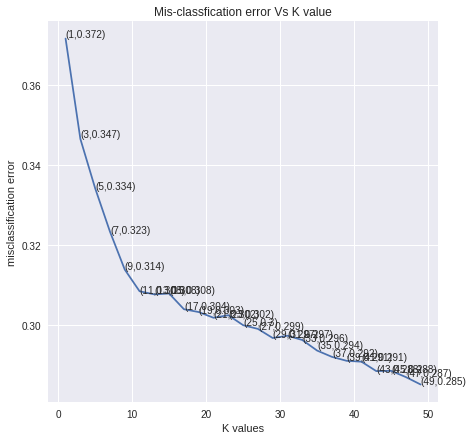

the misclassification error for each k value is :  [0.372 0.347 0.334 0.323 0.314 0.308 0.308 0.308 0.304 0.303 0.302 0.302
 0.3   0.299 0.297 0.297 0.296 0.294 0.292 0.291 0.291 0.288 0.288 0.287
 0.285]

The accuracy of the knn classifier for k = 49 is 70.750000%


In [87]:
#Optimal value for K-NN:
optimal_k_brute = knn(X_train_bow, y_train , 'brute')
knn_optimal(X_train_bow , y_train ,X_test_bow ,  optimal_k_brute)


 Optimal value among the all values of K = 49


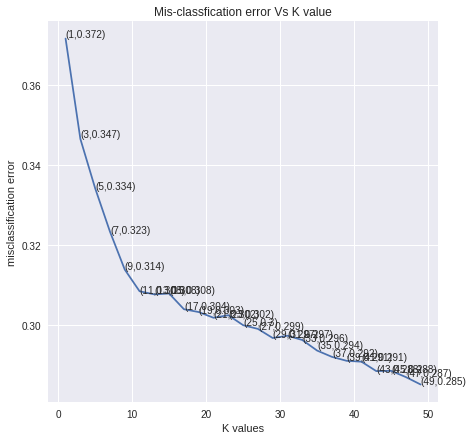

the misclassification error for each k value is :  [0.372 0.347 0.334 0.323 0.314 0.308 0.308 0.308 0.304 0.303 0.302 0.302
 0.3   0.299 0.297 0.297 0.296 0.294 0.292 0.291 0.291 0.288 0.288 0.287
 0.285]

The accuracy of the knn classifier for k = 49 is 70.750000%


In [70]:
#Computing the optimal_k value using the kd_tree:
optimal_k_kd_tree = knn(X_train , y_train , 'kd_tree')
knn_optimal(X_train , y_train , X_test_bow , optimal_k_kd_tree)

In [95]:
#Now we will split our train and test data and convert them to the TF - idf  vector:
X_train, X_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=55)
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)

(14000,) (14000,) (6000,) (6000,)


**KNN for TFIDF Vector: **

In [96]:
#Uni Gram  Train dataset Tf-IDF Vector:
tfidf_vector = TfidfVectorizer(ngram_range=(1,1) , min_df=5 )
X_train_tfidf= tfidf_vector.fit_transform(X_train)

print('X_train_tfidf.get_shape() : ' , X_train_tfidf.get_shape())


# Uni Gram Test dataset Tf-IDF Vectorizer:
X_test_tfidf= tfidf_vector.transform(X_test)

print('X_test_tfidf.get_shape():' , X_test_tfidf.shape)




X_train_tfidf.get_shape() :  (14000, 4703)
X_test_tfidf.get_shape(): (6000, 4703)



 Optimal value among the all values of K = 47


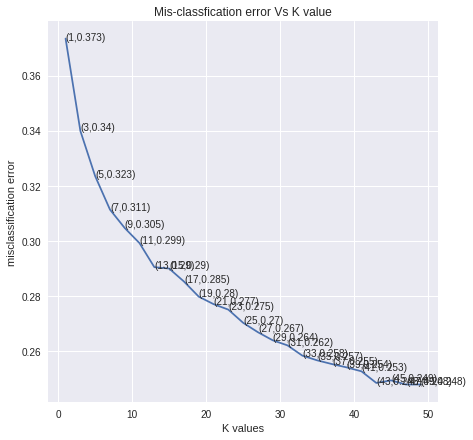

the misclassification error for each k value is :  [0.373 0.34  0.323 0.311 0.305 0.299 0.29  0.29  0.285 0.28  0.277 0.275
 0.27  0.267 0.264 0.262 0.258 0.257 0.255 0.254 0.253 0.248 0.249 0.248
 0.248]

The accuracy of the knn classifier for k = 49 is 75.616667%


In [98]:
#Optimal value for Brute Force K-NN:
optimal_k_brute = knn(X_train_tfidf, y_train , 'brute')

knn_optimal(X_train_tfidf , y_train ,X_test_tfidf ,  optimal_k_brute)


 Optimal value among the all values of K = 47


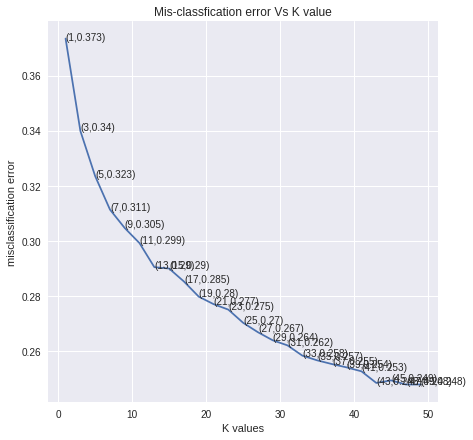

the misclassification error for each k value is :  [0.373 0.34  0.323 0.311 0.305 0.299 0.29  0.29  0.285 0.28  0.277 0.275
 0.27  0.267 0.264 0.262 0.258 0.257 0.255 0.254 0.253 0.248 0.249 0.248
 0.248]

The accuracy of the knn classifier for k = 49 is 75.616667%


In [99]:
#Optimal value for KD_tree K-NN:
optimal_k_kd_tree = knn(X_train_tfidf, y_train , 'kd_tree')

knn_optimal(X_train_tfidf , y_train ,X_test_tfidf ,optimal_k_kd_tree)

In [102]:
# Lets compute a list of list of words for Train Data to compute the wrod2vec:
# Now we will Train our own model using Word2vec:
list_of_sentence_train=[]
for sent in X_train:
    list_of_sentence_train.append(sent.split())

print(list_of_sentence_train[0])




['tri', 'sampl', 'like', 'sever', 'howev', 'tri', 'caribou', 'sale', 'elsewher', 'decid', 'full', 'bodi', 'other', 'smoother', 'order', 'four', 'pack', 'amazon']


In [0]:
# Creating the gensim model
import gensim
model = gensim.models.Word2Vec(list_of_sentence_train , min_count=5 , size=50 , workers=4)
vocab_list = list(model.wv.vocab)

In [110]:
# Lets compute a list of list of words for Train Data to compute the wrod2vec:
# Now we will Train our own model using Word2vec:
list_of_sentence_test=[]
for sent in X_test:
    list_of_sentence_test.append(sent.split())

print(list_of_sentence_test[0])


['pickl', 'amaz', 'tri', 'unremark', 'flavor', 'back', 'retail', 'manufactur', 'brand', 'pickl', 'noth', 'come', 'close', 'pickl', 'definit', 'repeat', 'custom']


**AVG Word2Vec**

In [111]:
#Computing the Average word2vec for Train Data:
sent_vect_train= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence_train):
    sen_vec = np.zeros(50) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect_train.append(sen_vec)

print(len(sent_vect_train))

print(len(sent_vect_train[0]))
        

100%|██████████| 14000/14000 [00:10<00:00, 1295.44it/s]

14000
50


In [0]:
# Creating the gensim model
import gensim
model = gensim.models.Word2Vec(list_of_sentence_test , min_count=5 , size=50 , workers=4)
vocab_list = list(model.wv.vocab)

In [116]:
#Computing the Average word2vec for Test  Data:
sent_vect_test= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence_test):
    sen_vec = np.zeros(50) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect_test.append(sen_vec)

print(len(sent_vect_test))

print(len(sent_vect_test[0]))
        

100%|██████████| 6000/6000 [00:03<00:00, 1514.85it/s]

6000
50



 Optimal value among the all values of K = 49


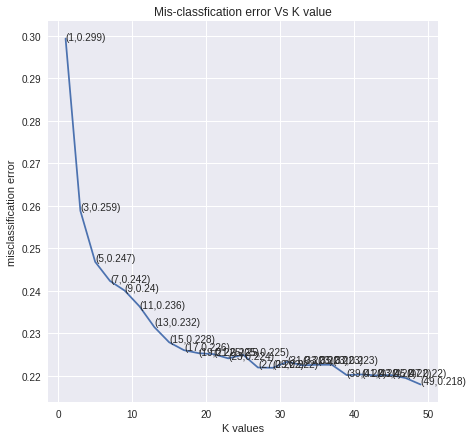

the misclassification error for each k value is :  [0.299 0.259 0.247 0.242 0.24  0.236 0.232 0.228 0.226 0.225 0.225 0.224
 0.225 0.222 0.222 0.223 0.223 0.223 0.223 0.22  0.22  0.22  0.22  0.22
 0.218]

The accuracy of the knn classifier on Test Data for k = 49 is 51.233333%


In [118]:
#Optimal value for KD_tree K-NN:
optimal_k_brute = knn(sent_vect_train, y_train , 'brute')

knn_optimal(sent_vect_train , y_train ,sent_vect_test ,optimal_k_brute)


 Optimal value among the all values of K = 49


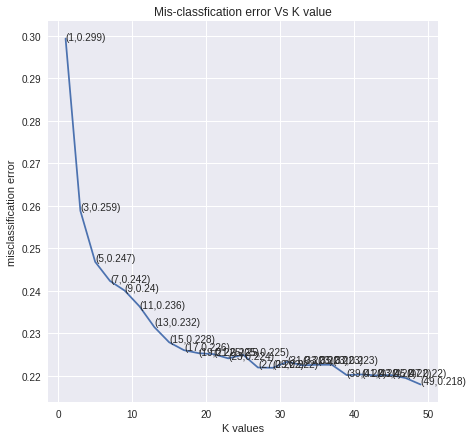

the misclassification error for each k value is :  [0.299 0.259 0.247 0.242 0.24  0.236 0.232 0.228 0.226 0.225 0.225 0.224
 0.225 0.222 0.222 0.223 0.223 0.223 0.223 0.22  0.22  0.22  0.22  0.22
 0.218]

The accuracy of the knn classifier on Test Data for k = 49 is 51.233333%


In [117]:
#Optimal value for KD_tree K-NN:
optimal_k_kd_tree = knn(sent_vect_train, y_train , 'kd_tree')

knn_optimal(sent_vect_train , y_train ,sent_vect_test ,optimal_k_kd_tree)

**K-NN for TFIDF Word2Vec**

In [0]:
#Computing the TF-idf values for the Train Data:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [0]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence_train , min_count=5 , size=50 , workers=4)
vocab_list = list(model.wv.vocab)

In [121]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors_train))

print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 14000/14000 [00:17<00:00, 796.90it/s]


 14000
50


In [0]:
#Computing the tf-idf values for the Test Data :

tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [0]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence_train , min_count=5 , size=50 , workers=4)
vocab_list=list(model.wv.vocab)

In [124]:
# TF-IDF weighted Word2Vec for Test Data:
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors_test))

print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 6000/6000 [00:05<00:00, 1031.87it/s]


 6000
50



 Optimal value among the all values of K = 47


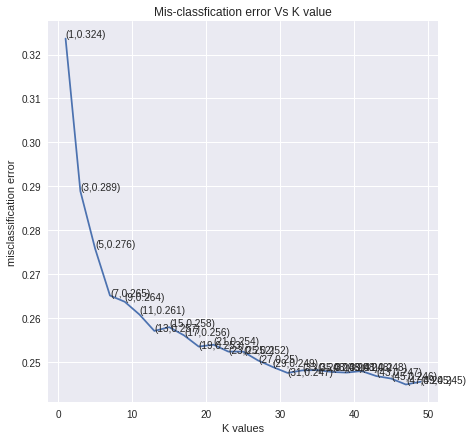

the misclassification error for each k value is :  [0.324 0.289 0.276 0.265 0.264 0.261 0.257 0.258 0.256 0.253 0.254 0.252
 0.252 0.25  0.249 0.247 0.248 0.248 0.248 0.248 0.248 0.247 0.246 0.245
 0.245]

The accuracy of the knn classifier on Test Data for k = 49 is 74.150000%


In [126]:
#Optimal value for KD_tree K-NN:
optimal_k_brute = knn(tfidf_sent_vectors_train, y_train , 'brute')

knn_optimal(tfidf_sent_vectors_train , y_train ,tfidf_sent_vectors_test ,optimal_k_brute)


 Optimal value among the all values of K = 47


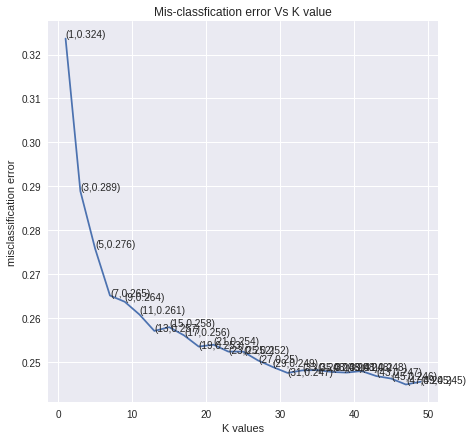

the misclassification error for each k value is :  [0.324 0.289 0.276 0.265 0.264 0.261 0.257 0.258 0.256 0.253 0.254 0.252
 0.252 0.25  0.249 0.247 0.248 0.248 0.248 0.248 0.248 0.247 0.246 0.245
 0.245]

The accuracy of the knn classifier on Test Data for k = 49 is 74.150000%


In [127]:
#Optimal value for KD_tree K-NN:
optimal_k_kd_tree = knn(tfidf_sent_vectors_train, y_train , 'kd_tree')

knn_optimal(tfidf_sent_vectors_train , y_train ,tfidf_sent_vectors_test ,optimal_k_kd_tree)